## Feed Forward Network 
Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In this notebook, we are focusing on creating a shallow consiting of 2 linear layers on which Relu and batch normalization is applied. 

After this we move forward to train our model on a deep network consisting of 4 linear layers on which Relu and Batch Normalization is applied. 

In [4]:
# Here we make all the imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange
import seaborn as sns
import json
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pytorchtools

# Model Definitions

Below we have defined our shallow and Deep layers. We tried different models by increasing and decreasing the number of linear layers. We also tried different dropout values. The following experiment showed us that the best model is the a deep structiure with 4 layers. Moving beyond this we start overfitting 

In [6]:
input_dim = 200
hidden_1 = 1000
hidden_2 = 256
output_dim = 2

class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        #self.fc5 = nn.Linear(32, 2)
        #self.fc6 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.fc6(x)
        output = F.log_softmax(x, dim=1)
        return output



The below function is used to divide the datasets into small chunks 

In [7]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

This code is used to import the Concat Embeddings of Images and Text and to load the Json files.

In [8]:
concat_embeddings = pd.read_csv("/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [9]:
train_data = pd.read_json("/content/drive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
batch_size = 32
chunked_data = split_dataframe(train_data, batch_size)

In [10]:
preds_train=[]
target_train =[]
preds_val=[]
target_val=[]

Code for training and validating the models 

In [11]:
def train(args, model, device, chunked_data, optimizer,criterion, concat_embeddings):
    model.train()

    for e in range(args['epochs']): 
      preds_train=[]
      target_train =[]
      avg_loss = 0.
      correct = 0
      total = 0
      for batch_idx, (data) in enumerate(chunked_data):
          id = data.id
          
          target = torch.Tensor(data.label.tolist()).to(device)
          a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
          if(len(a)==0):
            continue
          data = torch.Tensor(a).to(device)
          optimizer.zero_grad()
          output = model(data)

          loss = criterion(output, target.type(torch.cuda.LongTensor))
          avg_loss += loss.item()
          
          loss.backward()
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          #print(predicted.cpu().numpy())
          #print(target.cpu().numpy())
          # r= confusion_matrix(target.cpu().numpy(), predicted.cpu().numpy())
          p = predicted.cpu().numpy()
          t = target.cpu().numpy()
          
          preds_train.extend(p)
          target_train.extend(t)
         

          correct += (predicted.cpu() == target.cpu()).sum()
          optimizer.step()
      #print(preds_train)
      avg_loss /= len(chunked_data)
      print("Epoch : " + str(e)  + "  loss : " + str(avg_loss))
      precision, recall, f1, _ = precision_recall_fscore_support(preds_train, target_train, average='binary')
      r= confusion_matrix(preds_train, target_train)
      print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
      print("confusion_matrix")
      print(r)

      roc_auc = roc_auc_score(preds_train, target_train)
      print("roc",roc_auc)
      accuracy = 100.00 * correct.numpy() / total
      print("Epoch : " + str(e)  + "  accuracy : " + str(accuracy))


In [12]:
def post_train(args, model, device, chunked_data,criterion, concat_embeddings):
    model.eval()

    avg_loss = 0.
    correct = 0
    total = 0
    preds_val=[]
    target_val=[]
    for batch_idx, (data) in enumerate(chunked_data):
        id = data.id
        target = torch.Tensor(data.label.tolist()).to(device)
        a = concat_embeddings[concat_embeddings.id.isin(id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
        if(len(a)==0):
          continue
        data = torch.Tensor(a).to(device)
        output = model(data)
        #print(output.shape,target.shape)


        loss = criterion(output, target.type(torch.cuda.LongTensor))
        avg_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted.cpu() == target.cpu()).sum()
        p = predicted.cpu().numpy()
        t = target.cpu().numpy()
        preds_val.extend(p)
        target_val.extend(t)

    avg_loss /= len(chunked_data)
    precision, recall, f1, _ = precision_recall_fscore_support(preds_val, target_val, average='binary')
    precision1, recall1, thresholds = precision_recall_curve(preds_val, target_val)
    r= confusion_matrix(preds_val, target_val)
    accuracy = 100.00 * correct.numpy() / total
    fpr, tpr, _ = roc_curve(target_val, preds_val)

    print( "  accuracy : " + str(accuracy))
    print("  loss : " + str(avg_loss))
    print(" precision :"+str(precision) +" recall :"+str(recall)+" f1 "+ str(f1))
    print("confusion_matrix")
    print(r)
    roc_auc = roc_auc_score(preds_val, target_val)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)

    for i in range(r.shape[0]):
      for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
    
    print("roc",roc_auc)
    #plt.figure(1)

    #sns.heatmap(r,annot=True)
    plt.show()


    pyplot.plot(recall1, precision1, marker='.', label='Shallow_net')
    # axis labels
    print("Precison Vs Recall")
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.title('Precision Vs Recall', fontsize=20)
    # show the plot
    pyplot.show()

    print("ROC")

    # plt.plot([0, 1], [0, 1], 'k–')
    plt.plot(fpr, tpr, label='FNN_ROC(area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()




# Shallow : Train

In [13]:

model_shallow = BNShallowNet().to('cuda')
args = {'lr': 0.1, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_shallow.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_shallow, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.6136299188115767
 precision :0.425968863862206 recall :0.5675198587819947 f1 0.48666035950804165
confusion_matrix
[[4501 1733]
 [ 980 1286]]
roc 0.6447641000679303
Epoch : 0  accuracy : 68.08235294117647
Epoch : 1  loss : 0.5728100933190575
 precision :0.5041404438555813 recall :0.6245383668444809 f1 0.5579178885630499
confusion_matrix
[[4566 1497]
 [ 915 1522]]
roc 0.6888154476478713
Epoch : 1  accuracy : 71.62352941176471
Epoch : 2  loss : 0.5439161882924854
 precision :0.5495197085127526 recall :0.6585946804287416 f1 0.599133261105092
confusion_matrix
[[4621 1360]
 [ 860 1659]]
roc 0.7156039779003766
Epoch : 2  accuracy : 73.88235294117646
Epoch : 3  loss : 0.5233485367345182
 precision :0.5647565419012918 recall :0.6641994546162836 f1 0.610454708199069
confusion_matrix
[[4619 1314]
 [ 862 1705]]
roc 0.7213631690745332
Epoch : 3  accuracy : 74.4
Epoch : 4  loss : 0.5114891595186147
 precision :0.5876117919841007 recall :0.6786534047436878 f1 0.6298597550150897
co

# Shallow : Validation

Running the validation loss and accuarcy on the concat embeddings of dev seen and dev unseen csv

  accuracy : 45.74074074074074
  loss : 1.3074430718141443
 precision :0.625 recall :0.36443148688046645 f1 0.46040515653775316
confusion_matrix
[[122  75]
 [218 125]]
roc 0.49186041349099463


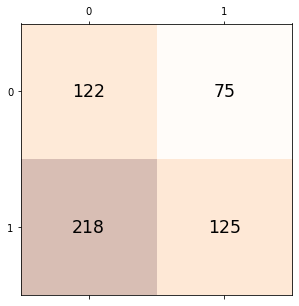

Precison Vs Recall


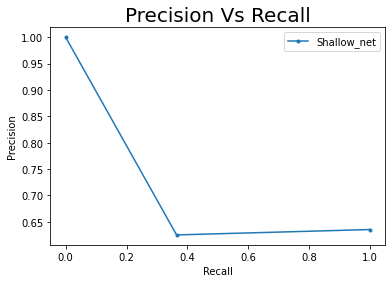

ROC


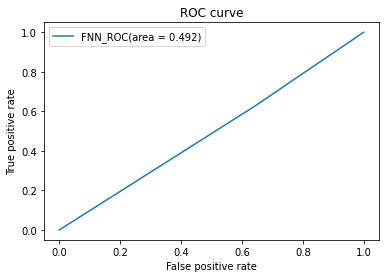

In [14]:

validation_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_dev_unseen.csv"]
concat_embeddings_validation = pd.concat( map(pd.read_csv, validation_paths), ignore_index=True)
concat_embeddings_validation.head()
concat_embeddings_validation.rename(columns={"0": "id"}, inplace=True)
batch_size = 32
val_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_data_unseen = val_data_unseen[val_data_unseen.id.isin(concat_embeddings_validation.id)]
chunked_data_validation = split_dataframe(val_data_unseen, batch_size)


args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Shallow : Test Unseen


  accuracy : 42.4
  loss : 1.3756773424527002
 precision :0.616 recall :0.34841628959276016 f1 0.4450867052023121
confusion_matrix
[[386 288]
 [864 462]]
roc 0.4605582931643326


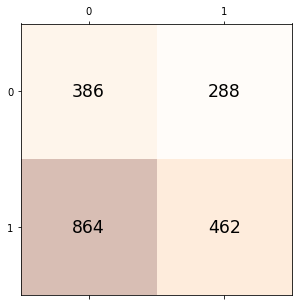

Precison Vs Recall


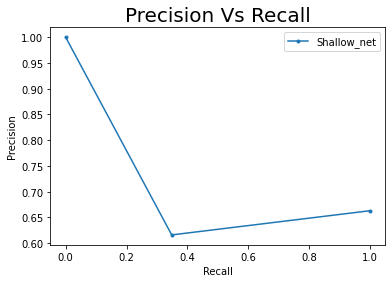

ROC


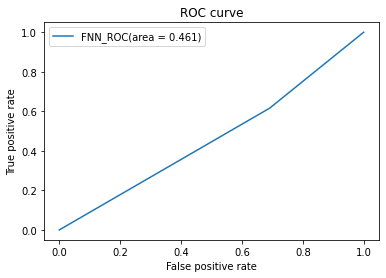

In [15]:
test_unseen_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_unseen.csv"]

concat_embeddings_test_unseen = pd.concat( map(pd.read_csv, test_unseen_paths), ignore_index=True)
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_unseen = pd.read_json("/content/drive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_data_unseen = test_data_unseen[test_data_unseen.id.isin(concat_embeddings_test_unseen.id)]
chunked_data_test_unseen = split_dataframe(test_data_unseen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)

# Shallow: Test Seen

  accuracy : 53.2
  loss : 1.0557345375418663
 precision :0.5775510204081633 recall :0.5202205882352942 f1 0.5473887814313347
confusion_matrix
[[249 207]
 [261 283]]
roc 0.5331366099071208


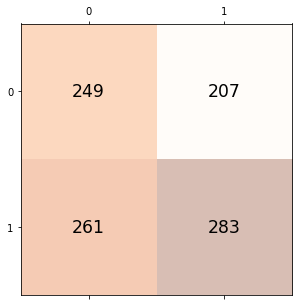

Precison Vs Recall


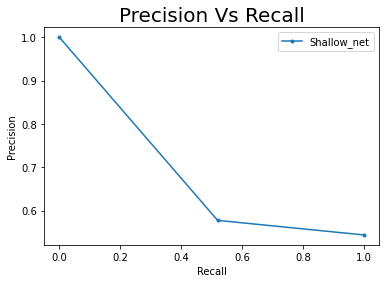

ROC


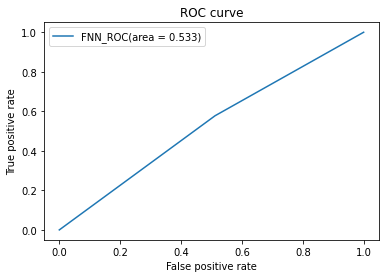

In [16]:
test_seen_paths = ["/content/drive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_seen.csv"]

concat_embeddings_test_seen = pd.concat( map(pd.read_csv, test_seen_paths), ignore_index=True)
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

batch_size = 32
test_data_seen = pd.read_json("/content/drive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_data_seen = test_data_seen[test_data_seen.id.isin(concat_embeddings_test_seen.id)]
chunked_data_test_seen = split_dataframe(test_data_seen, batch_size)

args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_shallow, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model : Training

In [17]:
import json
model_deep = BNDeepNet().to('cuda')
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
optimizer = optim.SGD(model_deep.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"

train(args, model_deep, device, chunked_data, optimizer, criterion, concat_embeddings)

Epoch : 0  loss : 0.683801370679884
 precision :0.1348128519377277 recall :0.34995700773860705 f1 0.19464371114299375
confusion_matrix
[[4725 2612]
 [ 756  407]]
roc 0.4969765957324628
Epoch : 0  accuracy : 60.37647058823529
Epoch : 1  loss : 0.6516846969611663
 precision :0.0241801921165949 recall :0.3924731182795699 f1 0.04555382215288612
confusion_matrix
[[5368 2946]
 [ 113   73]]
roc 0.5190655223343965
Epoch : 1  accuracy : 64.01176470588236
Epoch : 2  loss : 0.6408378078525228
 precision :0.029811195760185493 recall :0.5421686746987951 f1 0.056514913657770796
confusion_matrix
[[5405 2929]
 [  76   90]]
roc 0.5953583954247516
Epoch : 2  accuracy : 64.6470588235294
Epoch : 3  loss : 0.6319333122188884
 precision :0.07519046041735675 recall :0.6102150537634409 f1 0.1338838100855205
confusion_matrix
[[5336 2792]
 [ 145  227]]
roc 0.6333555583777835
Epoch : 3  accuracy : 65.44705882352942
Epoch : 4  loss : 0.6251569103477592
 precision :0.13580655846306725 recall :0.5815602836879432 f1

# Deep Model: Validation

  accuracy : 54.81481481481482
  loss : 0.7634350902893964
 precision :0.29 recall :0.3625 f1 0.32222222222222224
confusion_matrix
[[238 142]
 [102  58]]
roc 0.4944078947368421


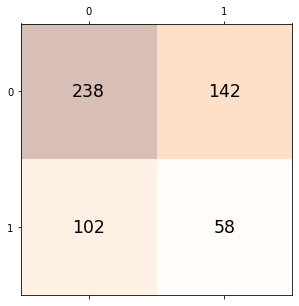

Precison Vs Recall


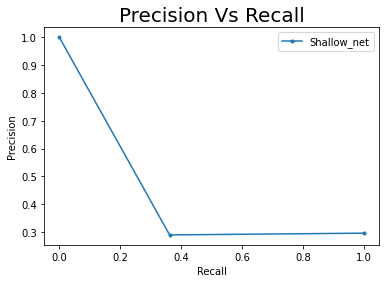

ROC


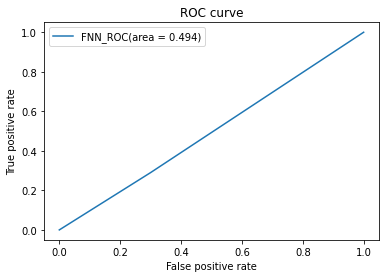

In [18]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_validation,criterion, concat_embeddings_validation)


# Deep Model: Test Seen 

  accuracy : 53.9
  loss : 0.7897742763161659
 precision :0.24285714285714285 recall :0.569377990430622 f1 0.34048640915593703
confusion_matrix
[[420 371]
 [ 90 119]]
roc 0.5501757208790278


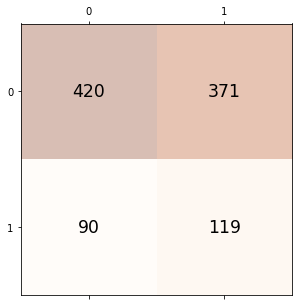

Precison Vs Recall


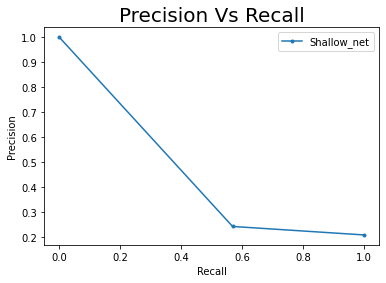

ROC


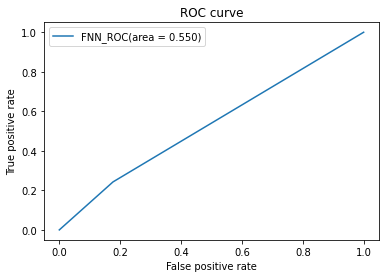

In [19]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_seen,criterion, concat_embeddings_test_seen)

# Deep Model: Test UnSeen

  accuracy : 55.45
  loss : 0.7699588433144584
 precision :0.24 recall :0.3592814371257485 f1 0.2877697841726619
confusion_matrix
[[929 570]
 [321 180]]
roc 0.4895139673954293


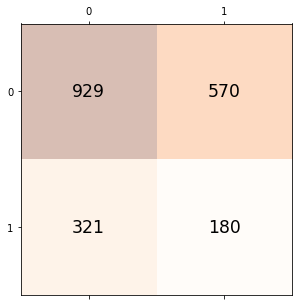

Precison Vs Recall


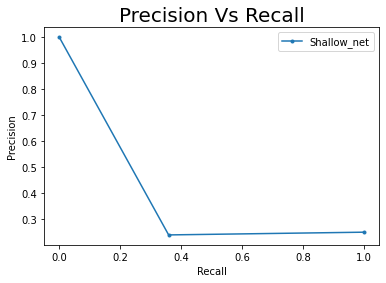

ROC


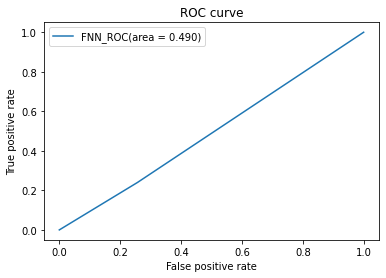

In [20]:
args = {'lr': 0.01, 'momentum': 0.1, "epochs" : 20}
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
criterion = nn.CrossEntropyLoss()
device = "cuda"
post_train(args, model_deep, device, chunked_data_test_unseen,criterion, concat_embeddings_test_unseen)